In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
import sys; sys.path.append("../offline/")
import sparse, geom, utils

In [3]:
import spimage

In [158]:
import scipy.optimize as optimize
import scipy.stats as stats
import scipy.ndimage as ndimage
import scipy.special as special

In [5]:
run = 95

In [6]:
assembled = []
with sparse.SmallFrame("../data/r%04d_lowq.h5" %run, geometry="../geometry/b3_lowq.geom") as f:
    for i in range(f.nframes):
        assembled.append(f.assembled(i))
    mask = f.activepixels
assembled = np.array(assembled)

In [7]:
hitscore = assembled.sum(axis=(1,2))

In [8]:
#assembled_sorted = assembled[np.argsort(hitscore)[::-1]][:,:300,:300]
assembled_sorted = assembled[:,:300,:300]

In [9]:
cmask = mask[:300,:300]

## Centering parameters

In [10]:
sh = assembled_sorted.shape[1:]
centering_maxshift  = 40
centering_threshold = 0.5
centering_blur      = 4
centering_x0 = sh[1]/2.
centering_y0 = sh[0]/2.

In [259]:
def rmask(r, sh, cx, cy):
    ny, nx = sh
    xx,yy = np.meshgrid(np.arange(nx), np.arange(ny))
    return (xx-cx)**2 + (yy-cy)**2 > (r**2)

## Pick a diffraction pattern

In [497]:
j = 6

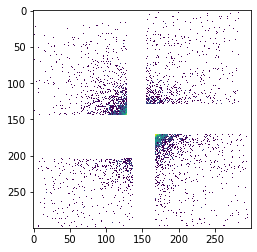

In [498]:
plt.imshow(assembled_sorted[j], norm=colors.LogNorm())

## Step 1. Finding the center

In [499]:
x,y = spimage.find_center(assembled_sorted[j],cmask,method='blurred', 
                          x0=centering_x0, y0=centering_y0,dmax=centering_maxshift, 
                          threshold=centering_threshold, blur_radius=centering_blur)
print("Step 1: Found center position (%.2f, %2.f)" %(x,y))

Step 1: Found center position (-7.50, 16)


## Step 2. Classification score

In [500]:
def pad_and_center(img, cx=0, cy=0, pad=50):
    imgp = np.pad(img, (pad,pad), mode='constant')
    imgr = np.roll(np.roll(imgp, -int(cy), axis=0), -int(cx), axis=1)
    return imgr

In [501]:
def loglike(n,I):
    return np.sum(n*np.log(I) - I - special.gammaln(n+1))

In [502]:
def likelihood(n,I):
    ll = loglike(n,I)
    return np.exp(ll - np.max(ll))

In [503]:
img = pad_and_center(assembled_sorted[j], cx=x,cy=y)
msk = pad_and_center(cmask, cx=x,cy=y)

In [504]:
rad1 = rmask(35,  msk.shape, msk.shape[1]/2, msk.shape[0]/2)
rad2 = ~rmask(100, msk.shape, msk.shape[1]/2, msk.shape[0]/2)

In [510]:
rot = np.linspace(0,180,50)
test = np.array([ndimage.interpolation.rotate(img, r, reshape=False) for r in rot])
#avg = np.array([ndimage.interpolation.rotate(img, r, reshape=False) for r in rot]).sum(axis=0)
#wgt = np.array([ndimage.interpolation.rotate(msk, r, reshape=False) for r in rot]).sum(axis=0)
#wgt[wgt==0] = 1.
#avg = ndimage.gaussian_filter(avg/wgt,1)

In [506]:
msk &= (avg>0)&rad1&rad2
avg *= (img[msk].sum() / avg[msk].sum())

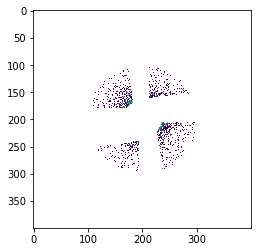

In [515]:
plt.imshow(test[2]*msk, norm=colors.LogNorm())

In [509]:
print(loglike(img[msk],img[msk]))

nan


/mnt/cbis/home/benedikt/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/mnt/cbis/home/benedikt/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [381]:
test = loglike(img,avg)

/mnt/cbis/home/benedikt/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/mnt/cbis/home/benedikt/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/mnt/cbis/home/benedikt/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


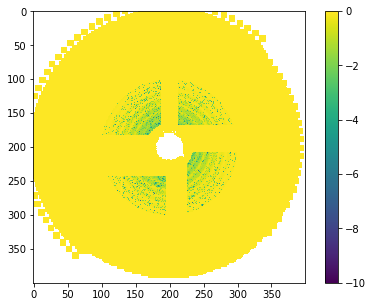

In [398]:
plt.figure(figsize=(7,5))
plt.imshow(test*msk, vmin=-10)
plt.colorbar()
plt.show()

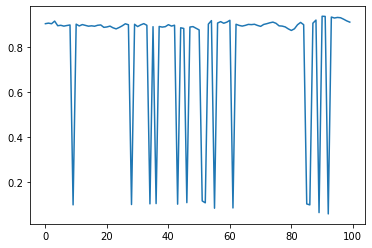

In [369]:
plt.plot(np.exp(loglike(img[msk],avg[msk]))[:100])

In [359]:
print(img[msk&(avg>0)&rad].mean())
print((avg/wgt)[msk&(avg>0)&(wgt>0)&rad].mean())

0.457704563218
0.0433023430978


In [360]:
print(stats.spearmanr(img[msk], (avg)[msk])[0])
print(np.mean((img[msk]-(avg)[msk])**2))

0.468864584952
0.491930869056


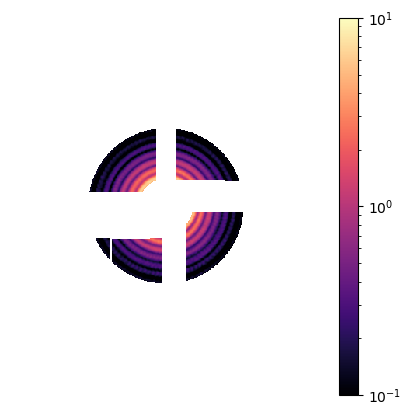

In [361]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(avg*msk, norm=colors.LogNorm(vmin=.1,vmax=10), cmap='magma')
plt.colorbar()
plt.show()

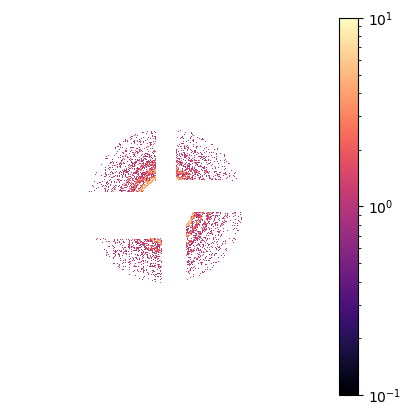

In [362]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(img*msk, norm=colors.LogNorm(vmin=.1,vmax=10), cmap='magma')
plt.colorbar()
plt.show()

## Step 2. Radial average

In [363]:
centers, radial1 = spimage.radialMeanImage(avg, msk=msk, cx=msk.shape[1]/2, 
                                          cy=msk.shape[0]/2, output_r=True)
centers, radial2 = spimage.radialMeanImage(img, msk=msk, cx=msk.shape[1]/2, 
                                          cy=msk.shape[0]/2, output_r=True)

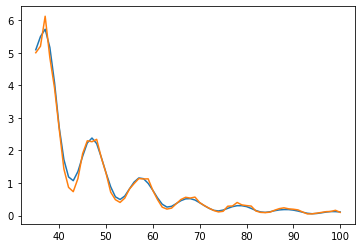

In [364]:
plt.plot(centers,radial1)
plt.plot(centers,radial2)

## Step 3. Fitting size/intensity

In [88]:
output = optimize.brute(costfunc1, [(1e-9,401e-9)], args=(data_r, mask_qr, data_qr), Ns=400, full_output=True)
diameter = output[0]
pearson = output[1]

In [89]:
diameter, pearson

(array([  1.76714282e-07]), 0.054912161000103987)

In [90]:
res = optimize.minimize(costfunc2, [intensity_start], args=(data_r, mask_qr, diameter, data_qr), 
                        method="Powell", tol=None, options={'disp':False})
intensity = res['x']
fun = res['fun']
print(intensity, fun)

60996556.48780775 20.9832035506


In [91]:
res = optimize.minimize(costfunc3, [diameter, intensity], args=(data_r, mask_qr, data_qr), 
                        method="Powell", tol=None, options={'disp':False})
diameter = res['x'][0]
intensity = res['x'][1]
fun = res['fun']

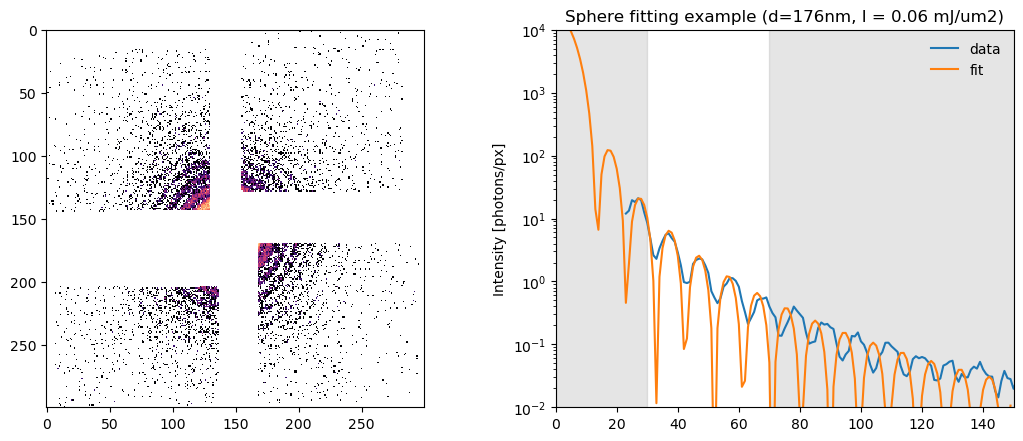

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5), dpi=100)
axes[0].imshow(assembled_sorted[j]*cmask, norm=colors.LogNorm(), cmap='magma')
axes[1].set_title("Sphere fitting example (d=%dnm, I = %.2f mJ/um2)" %(diameter*1e9, intensity / (1e-3 / 1e-12)))
axes[1].plot(data_qr, data_r, label="data")
axes[1].plot(qr, model([diameter,intensity],qr), label="fit")
axes[1].set_ylim(0.01, 1e4)
axes[1].set_xlim(0,sh[0]//2)
axes[1].axvspan(0,30, color='gray', alpha=0.2)
axes[1].axvspan(70,150, color='gray', alpha=0.2)
axes[1].semilogy()
axes[1].set_ylabel("Intensity [photons/px]")
axes[1].legend(frameon=0, loc=1)
plt.show()

In [93]:
def confidence(modelfunc, datay, datax, diameter, intensity, dmax=10e-9, imax=50, N=100, plevel=0.95):
    drange = np.linspace(diameter-dmax, diameter+dmax,N)
    irange = np.linspace(intensity*(1-imax/100.), intensity*(1+imax/100.),N)
    dd,ii = np.meshgrid(drange,irange)
    chisquared = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            fit = modelfunc([dd[j,i],ii[j,i]],datax)
            chisquared[j,i] = np.sum((fit-datay)**2)
    confmap = np.exp(-chisquared + chisquared.min())
    prob = (confmap/confmap.sum()).flatten()
    asort = np.argsort(prob)[::-1]
    confidence = prob[asort].cumsum() < plevel
    pmin = (prob[asort][confidence]*confmap.sum()).min()
    confmask = confmap > pmin 
    dlim = dd[confmask].min(), dd[confmask].max()
    ilim = ii[confmask].min(), ii[confmask].max()
    return confmap, dlim, ilim

In [94]:
C, dlim, ilim = confidence(model, data_r[mask_qr], data_qr[mask_qr], diameter, intensity)

In [95]:
derror = np.abs(diameter-dlim).max()/diameter
ierror = np.abs(intensity-ilim).max()/intensity

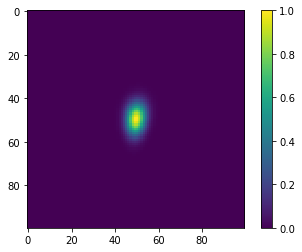

In [96]:
plt.imshow(C)
plt.colorbar()
plt.show()

In [97]:
print(derror, ierror, ierror, derror, derror/ierror)

[ 0.00858026] 0.116161616162 0.116161616162 [ 0.00858026] [ 0.07386485]
